# Practicing shift, log return

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_datareader.data as web #conda install pandas-datareader
import datetime
import pandas as pd
import numpy as np
from IPython.display import display

,level_0,Date,0
0,Price,2014-01-02,15.77406
1,Price,2014-01-03,15.53863
2,Price,2014-01-06,15.65164
3,Price,2014-01-07,15.21844
4,Price,2014-01-08,15.24669


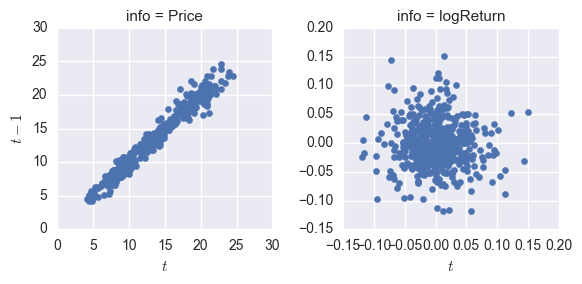

In [77]:
# retrieve data from yahoo
stocks = ['PETR4.SA']
ls_key = 'Adj Close'
start = datetime.datetime(2014,1,1)
end = datetime.datetime(2016,3,28)    
df = web.DataReader(stocks, 'yahoo',start,end)
df = pd.DataFrame(df.ix[ls_key])

# reshape data for one stock to plot
df.columns = ['Price']
df['logReturn'] = np.log(df['Price']/df['Price'].shift())
df = df.unstack().reset_index()
display(df[:5])

df.columns = ['info', 'date', '$t$']

df['$t-1$'] = None

df.ix[df['info']=='Price', '$t-1$'] = df.ix[df['info']=='Price', '$t$'].shift(3)


df.ix[df['info']=='logReturn', '$t-1$'] = df.ix[df['info']=='logReturn', '$t$'].shift(3)
#display(df)

# plot the lagged data
g = sns.FacetGrid(df, col='info', col_wrap=2, sharey=False, sharex=False)
g.map(plt.scatter, '$t$', '$t-1$');
plt.show()

# A Gentle Introduction to the Random Walk for Times Series Forecasting with Python
http://machinelearningmastery.com/gentle-introduction-random-walk-times-series-forecasting-python/


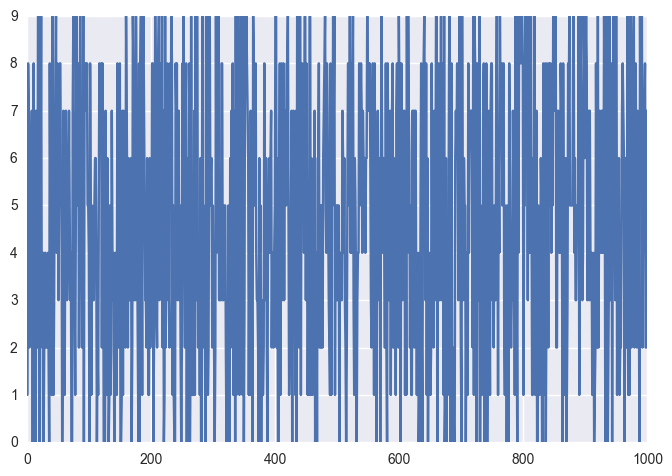

In [78]:
from random import seed
from random import randrange
from matplotlib import pyplot
seed(1)
series = [randrange(10) for i in range(1000)]
pyplot.plot(series)
pyplot.show()

## how to create random walk

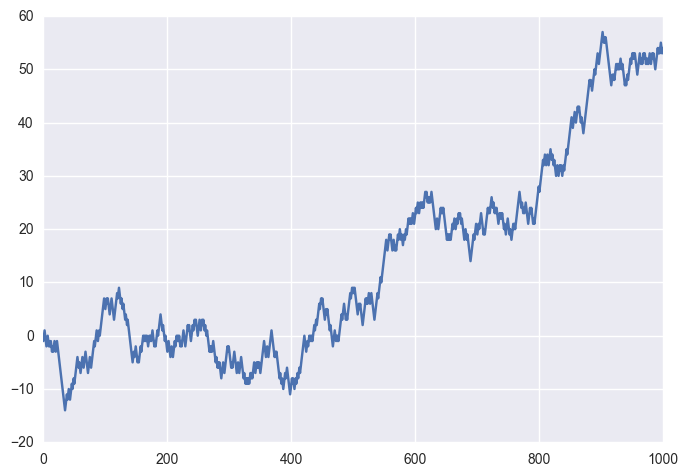

In [81]:
from random import seed
from random import random
from matplotlib import pyplot
seed(1)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)

for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)

pyplot.plot(random_walk)
pyplot.show()

## Checking autocorrelation

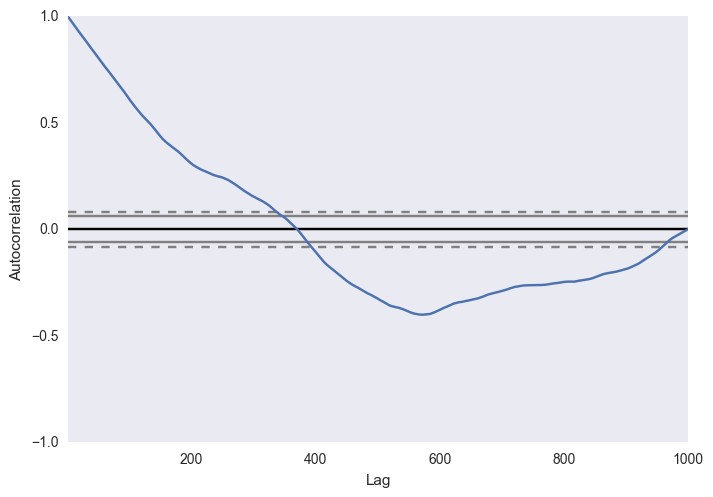

In [83]:
from pandas.tools.plotting import autocorrelation_plot
   
autocorrelation_plot(random_walk)
pyplot.show()

## Testing stationary on generated random walk-"it is non-stationary"

In [84]:
from statsmodels.tsa.stattools import adfuller

# statistical test #The null hypothesis of the test is that the time series is non-stationary.
result = adfuller(random_walk) 
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.341605
p-value: 0.979175
Critical Values:
	5%: -2.864
	1%: -3.437
	10%: -2.568


test statistic value was 0.341605. This is larger than all of the critical values at the 1%, 5%, and 10% confidence levels. Therefore, we can say that the time series does appear to be non-stationary with a low likelihood of the result being a statistical fluke.

## Make random walk as stationary by taking first differance -"No information/structure to learn!"

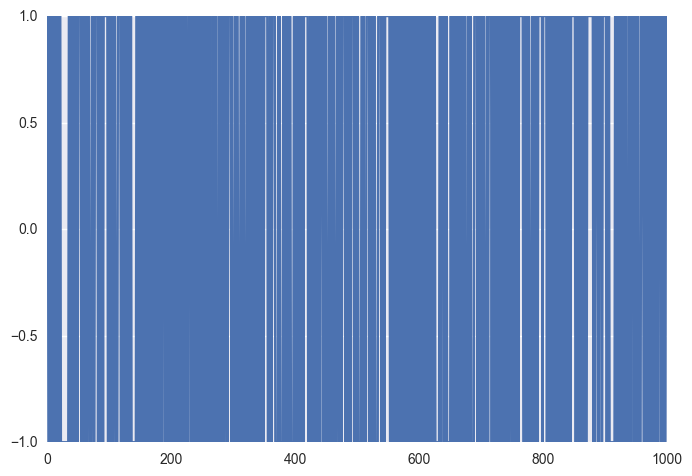

In [85]:
#make the random walk stationary by taking the first difference. 
diff = list()
for i in range(1, len(random_walk)):
    value = random_walk[i] - random_walk[i - 1]
    diff.append(value)

# line plot
pyplot.plot(diff)
pyplot.show()

This difference graph also makes it clear that really we have no information to work with here other than a series of random moves. There is no structure to learn.

Now that the time series is stationary, we can recalculate the correlogram of the differenced series.

## With stationary, recalculate correlogram-"no significant relationship between lagged observation"

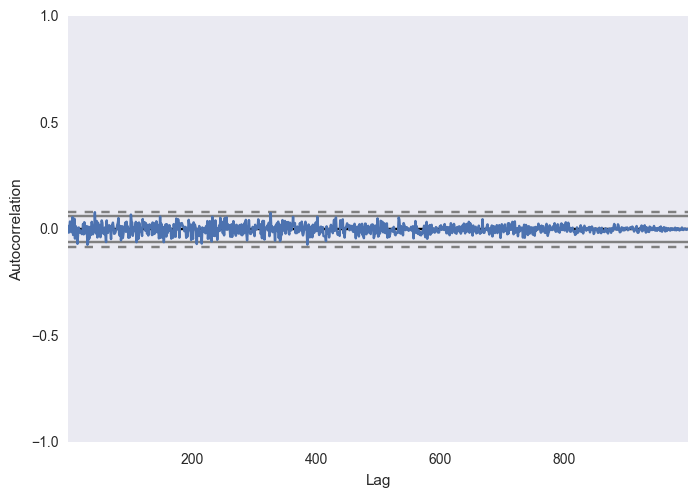

In [86]:
# line plot
autocorrelation_plot(diff)
pyplot.show()

we can see no significant relationship between the lagged observations, as we would expect from the way the random walk was generated. All correlations are small, close to zero and below the 95% and 99% confidence levels (beyond a few statistical flukes).

# Forcasting a Random Walk with naive forcast/persistence model

A random walk is unpredictable; it cannot reasonably be predicted.

Given the way that the random walk is constructed, we can expect that **the best prediction we could make would be to use the observation at the previous time step as what will happen in the next time step.Simply because we know that the next time step will be a function of the prior time step.**

This is often called the ** naive forecast** , or a ** persistence model**.

We can implement this in Python by first splitting the dataset into train and test sets, then **using the persistence model** to predict the outcome **using a rolling forecast method**. Once all predictions are collected for the test set, the mean squared error is calculated.

### (1) Predict using naive forcast/persistence model-"MSE=1"

In [90]:
from sklearn.metrics import mean_squared_error

# prepare dataset
train_size = int(len(random_walk) * 0.66)
train, test = random_walk[0:train_size], random_walk[train_size:]

# persistence
predictions = list()
history = train[-1]

for i in range(len(test)):
    yhat = history
    predictions.append(yhat)
    history = test[i]
    
error = mean_squared_error(test, predictions)
print('Persistence MSE: %.3f' % error)

Persistence MSE: 1.000


This too is expected, given that we know that the variation from one time step to the next is always going to be 1, either in the positive or negative direction, and the square of this expected error is 1 (1^2 = 1).

Another error that beginners to the random walk make is to assume that if the range of error (variance) is known, then we can make predictions **using a random walk generation type process**.

That is, if we know the error is either -1 or 1, then why not make predictions by adding a randomly selected -1 or 1 to the previous value.

We can demonstrate this random prediction method in Python below.

### (2) Predict using random walk generation type process assuming range of error is known. "EVEN WORSE than naive forcast!"

In [89]:
# random prediction
predictions = list()
history = train[-1]

for i in range(len(test)):
    yhat = history + (-1 if random() < 0.5 else 1)
    predictions.append(yhat)
    history = test[i]
    
error = mean_squared_error(test, predictions)
print('Random MSE: %.3f' % error)

Random MSE: 1.765


we can see that indeed the algorithm results in a worse performance than the persistence method, with a mean squared error of 1.765.
**Persistence, or the naive forecast, is the best prediction** we can make for a random walk time series.

# Is Your Time Series a Random Walk?

Your time series may be a random walk.

Some ways to check if your time series is a random walk are as follows:

- The time series shows a strong temporal dependence that decays linearly or in a similar pattern.
- The time series is non-stationary and making it stationary shows no obviously learnable structure in the data.
- The **persistence model provides the best source of reliable predictions.**

This last point is key for time series forecasting. Baseline forecasts with the persistence model quickly flesh out whether you can do significantly better. If you can’t, you’re probably working with a random walk.

Many time series are random walks, **particularly those of security prices over time.**

The random walk hypothesis is a theory that stock market prices are a random walk and cannot be predicted.

A random walk is one in which future steps or directions cannot be predicted on the basis of past history. When the term is applied to the stock market, it means that **short-run changes in stock prices are unpredictable.**

The human mind sees patterns everywhere and we must be vigilant that we are not fooling ourselves and wasting time by developing elaborate models for random walk processes.


# Forcasting with ARIMA Model - p207



Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


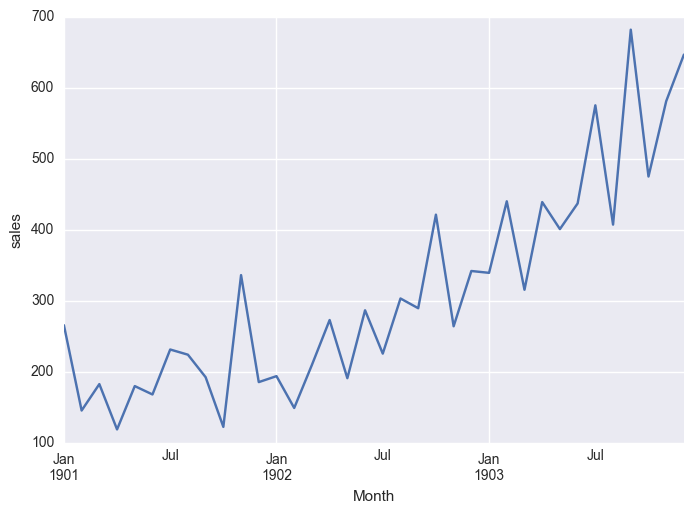

In [103]:
# load and plot dataset
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

# load dataset
def parser(x):
    return datetime.strptime('190'+x,  '%Y-%m')

series = read_csv('/Users/parksoy/Desktop/python_pro_bundle/time_series_forecasting_with_python/code/chapter_24/shampoo-sales.csv', 
                  header=0, parse_dates=[0], index_col=0,
                  squeeze=True, date_parser=parser)

# summarize first few rows
print(series.head())

# line plot
ax=series.plot()
ax.set_ylabel('sales')
pyplot.show()

In [148]:
print series.index

DatetimeIndex(['1901-01-01', '1901-02-01', '1901-03-01', '1901-04-01',
               '1901-05-01', '1901-06-01', '1901-07-01', '1901-08-01',
               '1901-09-01', '1901-10-01', '1901-11-01', '1901-12-01',
               '1902-01-01', '1902-02-01', '1902-03-01', '1902-04-01',
               '1902-05-01', '1902-06-01', '1902-07-01', '1902-08-01',
               '1902-09-01', '1902-10-01', '1902-11-01', '1902-12-01',
               '1903-01-01', '1903-02-01', '1903-03-01', '1903-04-01',
               '1903-05-01', '1903-06-01', '1903-07-01', '1903-08-01',
               '1903-09-01', '1903-10-01', '1903-11-01', '1903-12-01'],
              dtype='datetime64[ns]', name=u'Month', freq=None)


We can see that the Shampoo Sales dataset has a clear trend. This suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1. Let’s also take a quick look at an autocorrelation plot of the time series. This is also built-in to Pandas. The example below plots the autocorrelation for a large number of lags in the time series.

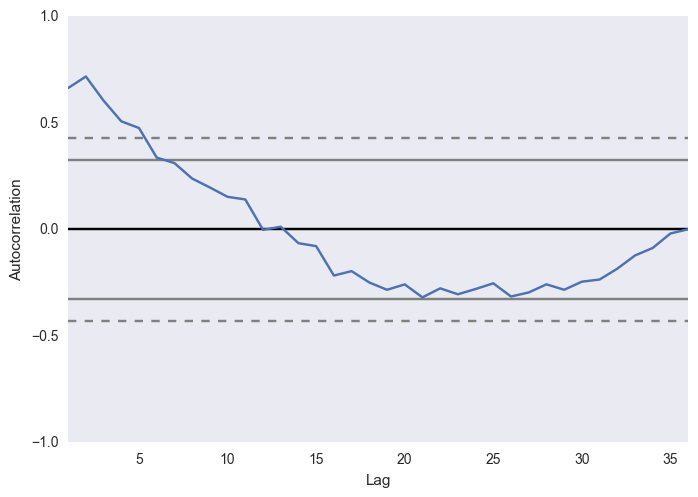

In [95]:
# autocorrelation plot
autocorrelation_plot(series)
pyplot.show()

Running the example, we can see that there is a positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags. A good starting point for the AR parameter of the model may be 5.

We will fit an ARIMA model to the entire Shampoo Sales dataset and review the residual errors. First, we fit an ARIMA(5,1,0) model. 

- This sets the lag value to 5 for autoregression,   
- uses a difference order of 1 to make the time series stationary, and   
- uses a moving average model of 0.   


    #p: The number of lag observations included in the model, also called the lag order.
    #d: The number of times that the raw observations are differenced, also called the degree of differencing.
    #q: The size of the moving average window, also called the order of moving average.

When fitting the model, a lot of debug information is provided about the fit of the linear regression model. We can turn this off by setting the disp argument to 0.

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -196.170
Method:                       css-mle   S.D. of innovations             64.241
Date:                Mon, 13 Mar 2017   AIC                            406.340
Time:                        12:48:19   BIC                            417.227
Sample:                    02-01-1901   HQIC                           410.098
                         - 12-01-1903                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const            12.0649      3.652      3.304      0.003         4.908    19.222
ar.L1.D.Sales    -1.1082      0.183     -6.063      0.000        -1.466    -0.750
ar.L2.D.Sales    -0.6203      0.282     

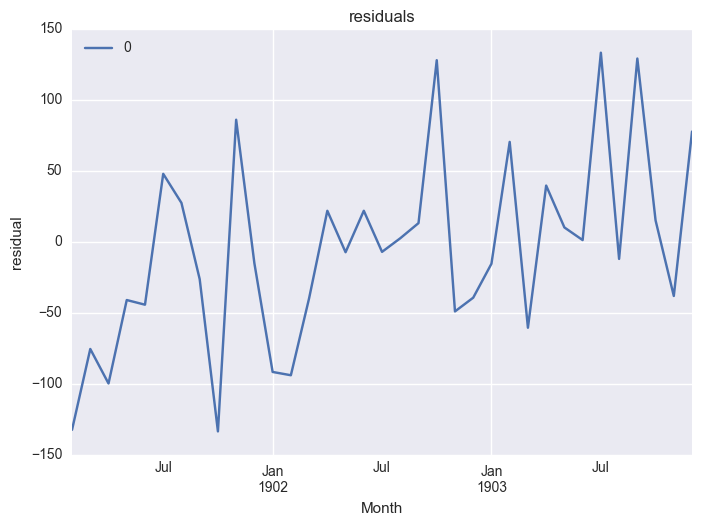

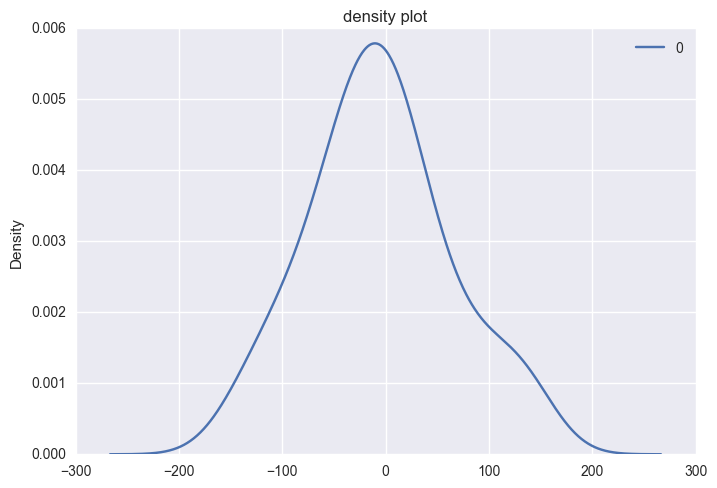

                0
count   35.000000
mean    -5.495173
std     68.132884
min   -133.296558
25%    -42.477882
50%     -7.186539
75%     24.748391
max    133.238005


In [104]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from matplotlib import pyplot

# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)

# summary of fit model
print(model_fit.summary())

# line plot of residuals
residuals = DataFrame(model_fit.resid)
ax=residuals.plot(title='residuals')
ax.set_ylabel('residual')
pyplot.show()

# density plot of residuals
residuals.plot(kind= 'kde', title='density plot' )
pyplot.show()

# summary stats of residuals
print(residuals.describe())

First, we get **a line plot of the residual errors, suggesting that there may still be some trend information not captured by the model.**

Next, we get a density plot of the residual error values, suggesting the errors are Gaussian, but **may not be centered on zero. The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).**

Note, that although above we used the entire dataset for time series analysis, ideally we would perform this analysis on just the training dataset when developing a predictive model. Next, let’s look at how we can use the ARIMA model to make forecasts.


# 24.4 Rolling Forecast with ARIMA Model

The ARIMA model can be used to forecast future time steps. We can use the predict() function on the ARIMAResults object [4](http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.arima_model.ARIMAResults.html) to make predictions. It accepts the index of the time steps to make predictions as arguments. These indexes are relative to the start of the training dataset used to make predictions.

If we used 100 observations in the training dataset to fit the model, then the index of the next time step for making a prediction would be specified to the prediction function as start=101, end=101. This would return an array with one element containing the prediction. We also would prefer the forecasted values to be in the original scale, in case we performed any differencing (d > 0 when configuring the model). This can be specified by setting the typ argument to the value ’levels’: typ=’levels’.

Alternately, we can avoid all of these specifications by using the forecast() function [5](http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.arima_model.ARIMAResults.forecast.html) which performs a one-step forecast using the model. We can split the training dataset into train and test sets, use the train set to fit the model, and generate a prediction for each element on the test set.

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to     
        **-  re-create the ARIMA model after each new observation is received. **  
        **-  We manually keep track of all observations in a list called history     **  
        **-  history is seeded with the training data and to which new observations are appended each iteration.   **
    
Putting this all together, below is an example of a rolling forecast with the ARIMA model in Python.


In [208]:
#Soyoung: Process as series so I know what day forcast is made

# split into train and test sets
X = series#.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

# walk-forward validation
#p: The number of lag observations included in the model, also called the lag order.
#d: The number of times that the raw observations are differenced, also called the degree of differencing.
#q: The size of the moving average window, also called the order of moving average.

for t in range(len(test)):
    model = ARIMA(history, order=(5,2,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions.append(yhat)
    observ = test[t]
    history.append(observ)
    print( 'predicted=%f, expected=%f'  % (yhat, observ))
    
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print( 'Test RMSE: %.3f'  % rmse)

predicted=426.752612, expected=342.300000
predicted=342.322730, expected=339.700000
predicted=415.575508, expected=440.400000
predicted=379.418158, expected=315.900000
predicted=393.701794, expected=439.300000
predicted=378.874872, expected=401.300000
predicted=497.615482, expected=437.400000
predicted=421.250780, expected=575.500000
predicted=505.199833, expected=407.600000
predicted=570.627613, expected=682.000000
predicted=529.954219, expected=475.300000
predicted=720.750439, expected=581.300000
predicted=613.988255, expected=646.900000
Test RMSE: 81.918


,pred_y,test_y
Month,,
1902-12-01,426.752612,342.3
1903-01-01,342.322730,339.7
1903-02-01,415.575508,440.4
1903-03-01,379.418158,315.9
1903-04-01,393.701794,439.3
1903-05-01,378.874872,401.3
1903-06-01,497.615482,437.4
1903-07-01,421.250780,575.5
1903-08-01,505.199833,407.6


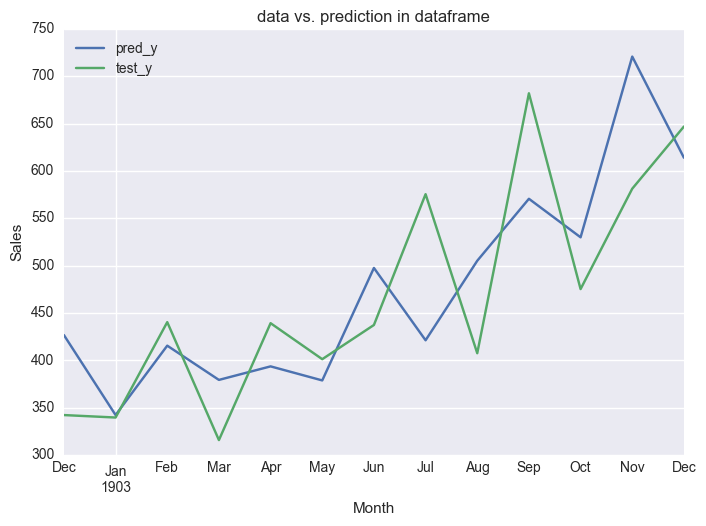

In [209]:
#Soyoung: Deal with dataframe and plot pred vs. test data

test_y = DataFrame({'test_y':test}, index=test.index)
prediction_y=pd.Series( (v[0] for v in predictions))
prediction_y_df=pd.DataFrame({'pred_y':[v[0] for v in predictions]},  index=test.index)

test_pred_y=prediction_y_df.join(test_y)
display(test_pred_y)
ax=test_pred_y.plot(title='data vs. prediction in dataframe')
ax.set_ylabel('Sales')
pyplot.show()

In [187]:
train_df=DataFrame({'train':train}, index=train.index)
display(train_df)

,train
Month,
1901-01-01,266.0
1901-02-01,145.9
1901-03-01,183.1
1901-04-01,119.3
1901-05-01,180.3
1901-06-01,168.5
1901-07-01,231.8
1901-08-01,224.5
1901-09-01,192.8


In [153]:
# Book: evaluate an ARIMA model using a walk-forward validation

from math import sqrt

# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
#p: The number of lag observations included in the model, also called the lag order.
#d: The number of times that the raw observations are differenced, also called the degree of differencing.
#q: The size of the moving average window, also called the order of moving average.

    
for t in range(len(test)):

    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print( 'predicted=%f, expected=%f'  % (yhat, obs))
    
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print( 'Test RMSE: %.3f'  % rmse)

predicted=349.117710, expected=342.300000
predicted=306.513008, expected=339.700000
predicted=387.376410, expected=440.400000
predicted=348.154128, expected=315.900000
predicted=386.308796, expected=439.300000
predicted=356.081983, expected=401.300000
predicted=446.379474, expected=437.400000
predicted=394.737288, expected=575.500000
predicted=434.915471, expected=407.600000
predicted=507.923445, expected=682.000000
predicted=435.482955, expected=475.300000
predicted=652.743805, expected=581.300000
predicted=546.343501, expected=646.900000
Test RMSE: 83.417


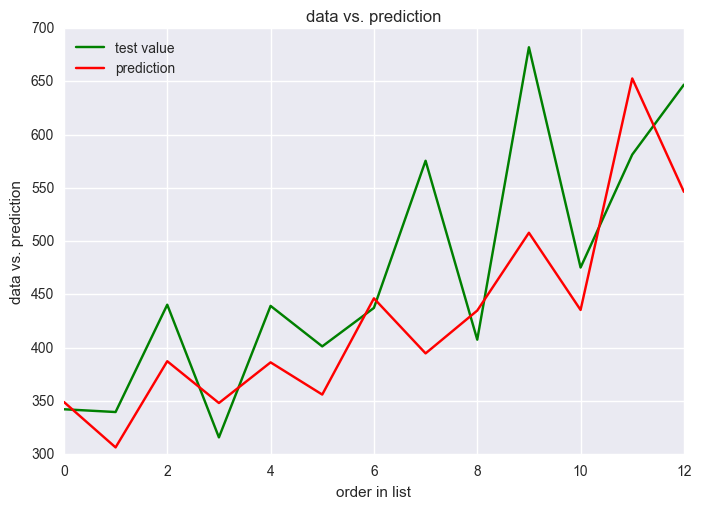

In [143]:
# plot forecasts against actual outcomes-this is with list and np array
import matplotlib.pyplot as plt

plt.plot(test, color= 'green',label='test value')
plt.plot(predictions, color= 'red' ,label='prediction')
plt.ylabel('data vs. prediction')
plt.xlabel('order in list')
plt.title('data vs. prediction')
plt.legend(loc='best')
plt.show()

Running the example prints the prediction and expected value each iteration. We can also calculate a final root mean squared error score (RMSE) for the predictions, providing a point of comparison for other ARIMA configurations.

The model could use further tuning of the p, d, and maybe even the q parameters.
